In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%pip install -U tensorflow tensorflow.keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 115.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflo

# Build The U-Net Model

First let's look at the model architecture to have an idea about its components, its layers, the dimensions of each layer, etc..

The convolutional neural network has a U-shaped architecture with an encoder and a decoder connected by skip connections.

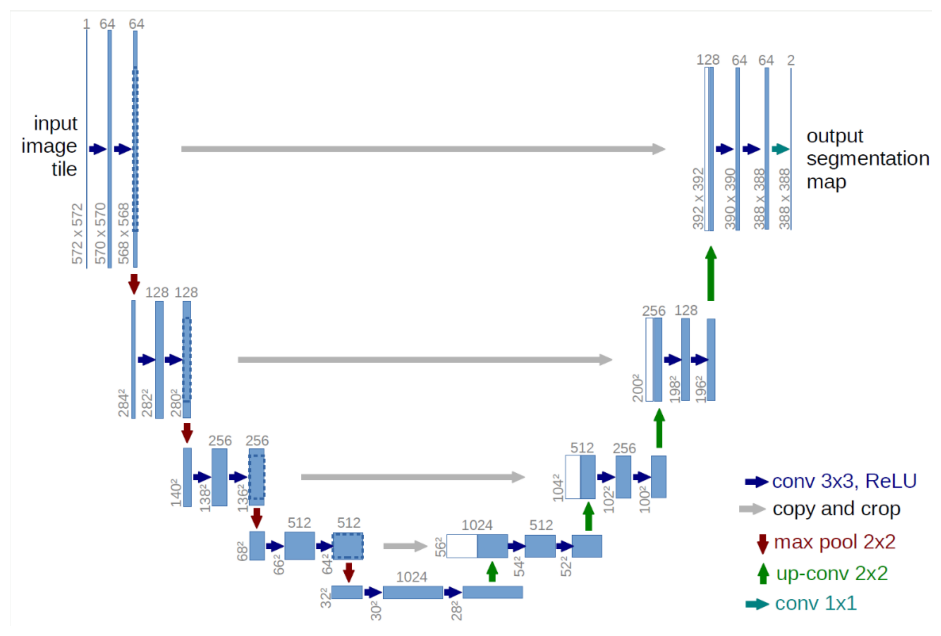

In [ ]:
# U-Net Architecture
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/drive/MyDrive/4A_GIIADS/Brain_Tumor_Segmentation_Project/u-net_architecture.png')
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

## Encoder :    

The input first goes through a contraction path where the input size is downsampled

In the image above, the input has a size of 572 x 572, with the single chanel (1) because the input is gray scaled

But the ouput is 388 x 388 and has 2 channels, because we have 2 classes.
In our case we have 4 classes (4 labels : 0, 1, 2 and 4)

The ouput and the input has different sizes, but it's mainly because we use paddings on the input that's why it has a larger size

The first step is to start with the 2 convolution layers ( that's why the size is reduced slightely) with a 64 filter aka channels

Then we do downsampling using maxpooling layer , then again 2 conv layers and dubbeling the channels from 64 to 128

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
import tensorflow as tf

# Input dimensions (BraTS2020 uses 144x144x144x4)
img_width = 144
img_height = 144
img_depth = 144 # 144 is the 3D img size, and is divisable by 16
kernel_initializer = 'he_normal'

#Define the input layer
inputs = Input((img_width, img_height, img_depth, 3), name='input_1', dtype=tf.float32)


# Encoder: Contracting path
# Normalize input by dividing by 255 : Convert the input layer from integers to floating points by devinding each pixel by 255
# s = Lambda(lambda x: x / 255)(inputs)
s = inputs

#Contraction path
c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
p1 = MaxPooling3D((2, 2, 2))(c1)

c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
p2 = MaxPooling3D((2, 2, 2))(c2)

c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
p3 = MaxPooling3D((2, 2, 2))(c3)

c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

#Expansive path
u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
u9 = concatenate([u9, c1])
c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

# We are going to use the softmax activation function since we have multiple classes ( 4 classes )
# Output layer (4 classes: 0,1,2,3)
outputs = Conv3D(4, (1,1,1), activation='softmax')(c9)

model = Model(inputs=inputs, outputs=outputs)

loss=tf.keras.losses.CategoricalCrossentropy()

# Here we are going to use the 'adam' optimizer, it a module that contains a lot of back-propagation algorithms that can train our model
# The optimizer will try to minimize the loss function"
# Here, we used categorical crossentropy loss for multi-class classification. Once it finds the minimum of this function, the iterations will stop
# And to mesure the model performance after training we used the 'accuracy' metric
model.compile(optimizer=Adam(learning_rate=0.001),
              loss= loss,
              metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)      │ (None, 144, 144, 144,  │              0 │ -                      │
│                           │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_57 (Conv3D)        │ (None, 144, 144, 144,  │          1,312 │ input_1[0][0]          │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_27 (Dropout)      │ (None, 144, 144, 144,  │              0 │ conv3d_57[0][0]        │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_58 (Conv3D)        │ (None, 144, 144, 144,  │          6,928 │ dropout_27[0][0]       │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_12          │ (None, 72, 72, 72, 16) │              0 │ conv3d_58[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_59 (Conv3D)        │ (None, 72, 72, 72, 32) │         13,856 │ max_pooling3d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_28 (Dropout)      │ (None, 72, 72, 72, 32) │              0 │ conv3d_59[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_60 (Conv3D)        │ (None, 72, 72, 72, 32) │         27,680 │ dropout_28[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_13          │ (None, 36, 36, 36, 32) │              0 │ conv3d_60[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_61 (Conv3D)        │ (None, 36, 36, 36, 64) │         55,360 │ max_pooling3d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_29 (Dropout)      │ (None, 36, 36, 36, 64) │              0 │ conv3d_61[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_62 (Conv3D)        │ (None, 36, 36, 36, 64) │        110,656 │ dropout_29[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_14          │ (None, 18, 18, 18, 64) │              0 │ conv3d_62[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_63 (Conv3D)        │ (None, 18, 18, 18,     │        221,312 │ max_pooling3d_14[0][0] │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_30 (Dropout)      │ (None, 18, 18, 18,     │              0 │ conv3d_63[0][0]        │
│                           │ 128)                   │                │                        │
├──────────────────────

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

# Test if everything is working ok.

In [ ]:
print(model.input_shape)
print(model.output_shape)

(None, 144, 144, 144, 3)
(None, 144, 144, 144, 4)


# Train the model

## Data Generator

In [ ]:
%pip install split-folders nibabel

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import splitfolders
import os

# Paths
images_dir = "/content/drive/MyDrive/Brain_Tumor_Segmentation_Project/data_Processed/BraTS2020_TrainingData_Processed_images/"
masks_dir = "/content/drive/MyDrive/Brain_Tumor_Segmentation_Project/data_Processed/BraTS2020_TrainingData_Processed_masks/"

# Get all patient IDs
patient_ids = [f.split("_flair.nii")[0] for f in os.listdir(images_dir) if f.endswith("_flair.nii")]

# Split into train (80%) and validation (20%)
train_ids, val_ids = train_test_split(patient_ids, test_size=0.2, random_state=42)

In [ ]:
import os
import numpy as np
import nibabel as nib

def data_generator(images_dir, masks_dir, patient_ids, batch_size=2):
    while True:
        for i in range(0, len(patient_ids), batch_size):
            batch_patients = patient_ids[i:i + batch_size]
            X_batch = []
            Y_batch = []

            for patient_id in batch_patients:
                modalities = []
                for modality in ['flair', 't1ce', 't2']:
                    img_path = os.path.join(images_dir, f"{patient_id}_{modality}.nii")
                    img = nib.load(img_path).get_fdata()  # Shape: [H, W, D]
                    modalities.append(img)

                # Stack modalities
                stacked_img = np.stack(modalities, axis=3)
                X_batch.append(stacked_img)

                mask_path = os.path.join(masks_dir, f"{patient_id}_seg.nii")
                mask = nib.load(mask_path).get_fdata().astype(np.uint8)

                Y_batch.append(mask[..., :4])

            #yield (X_batch,Y_batch)
            yield np.array(X_batch, dtype=np.float32), np.array(Y_batch, dtype=np.float32)


In [ ]:
images_dir = "/content/drive/MyDrive/Brain_Tumor_Segmentation_Project/data_Processed/BraTS2020_TrainingData_Processed_images/"
masks_dir = "/content/drive/MyDrive/Brain_Tumor_Segmentation_Project/data_Processed/BraTS2020_TrainingData_Processed_masks/"

patient_ids = [f"BraTS20_Training_{i:03d}" for i in range(1, 370)]  # 369 patients

# Create the data generator
generator = data_generator(images_dir, masks_dir, patient_ids, batch_size=4)

## Train the model

In [ ]:
batch_size = 2
train_img_datagen = data_generator(images_dir, masks_dir, train_ids, batch_size=batch_size)
val_img_datagen = data_generator(images_dir, masks_dir, val_ids, batch_size=batch_size)

steps_per_epoch = len(train_ids)//batch_size
val_steps_per_epoch = len(val_ids)//batch_size

def wrap_generator(generator):
    for x, y in generator:
        #yield {'input_1': x}, y
        yield x, y

In [ ]:
history=model.fit(
          wrap_generator(train_img_datagen),
          steps_per_epoch=steps_per_epoch,
          epochs=30,
          validation_data= wrap_generator(val_img_datagen),
          validation_steps=val_steps_per_epoch
          )

model.save('u_net_model.hdf5')

Epoch 1/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 3237s 22s/step - accuracy: 0.9416 - loss: 0.4479 - val_accuracy: 0.9656 - val_loss: 0.1598
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 3002s 20s/step - accuracy: 0.9681 - loss: 0.1370 - val_accuracy: 0.9707 - val_loss: 0.1066
Epoch 3/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 3087s 21s/step - accuracy: 0.9722 - loss: 0.0982 - val_accuracy: 0.9761 - val_loss: 0.0805
Epoch 4/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 2986s 20s/step - accuracy: 0.9713 - loss: 0.1128 - val_accuracy: 0.9723 - val_loss: 0.0930
Epoch 5/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 2858s 19s/step - accuracy: 0.9700 - loss: 0.1139 - val_accuracy: 0.9724 - val_loss: 0.0931
Epoch 6/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 2853s 19s/step - accuracy: 0.9754 - loss: 0.0796 - val_accuracy: 0.9732 - val_loss: 0.0944
Epoch 7/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 2857s 19s/step - accuracy: 0.9757 - loss: 0.0825 - val_accuracy: 0.9770 - val_loss: 0.0713
Epoch 8/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 2856s 19s/step - accuracy: 0.9767 - loss: 0